![Py4Eng](img/logo.png)

# Numba: just-in-time compilation for numerical computation
## Yoav Ram

# Numba

[Numba]((http://numba.pydata.org) speeds functions written directly in Python. 
With a few annotations, array-oriented and math-heavy Python code can be *just-in-time* (JIT) compiled to native machine instructions, similar in performance to C, C++ and Fortran, without having to switch languages or Python interpreters.

Roughly, [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation) compilation combines the speed of compiled code with the flexibility of interpretation, with the overhead of an interpreter and the additional overhead of compiling (not just interpreting).

Numba also allows to release the GIL, thus allowing multithreading in CPU-bounded applications. 
It also allows to automatically parallelize code.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numba
print('Numba', numba.__version__, "with NumPy", np.__version__)
import Cython
%load_ext Cython

Numba 0.61.0 with NumPy 2.1.3


# Mandelbrot fractal

We start with Mandelbrot's fractal, which we already saw in the [Cython](cython.ipynb) session.

In [10]:
def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

CPU times: user 1.01 s, sys: 4.35 ms, total: 1.01 s
Wall time: 1.01 s


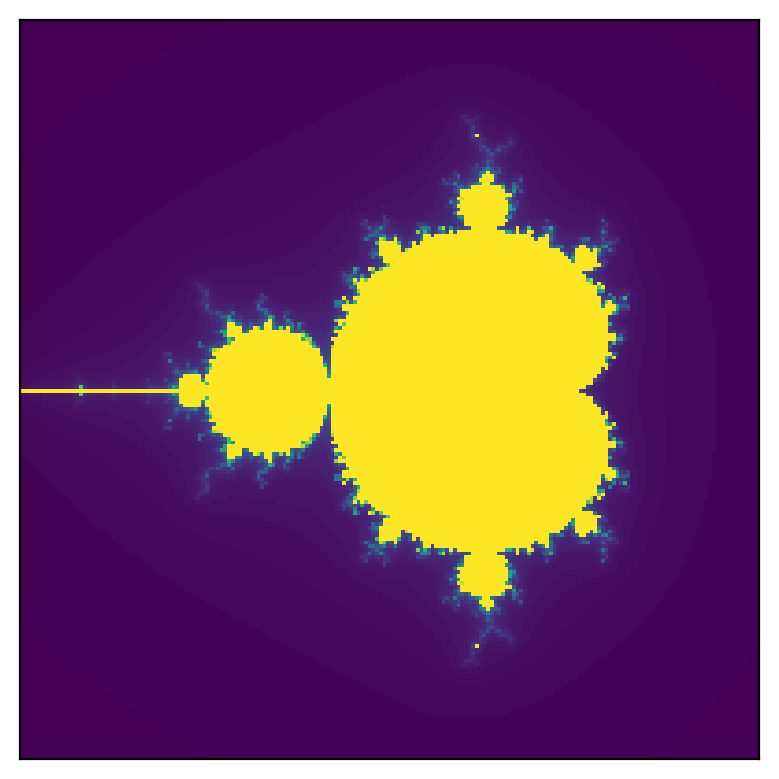

In [12]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)

%time mandelbrot(m, size, iterations)
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

Now we can use Numba to just-in-time compile `mandelbrot` using `njit`.

In [13]:
nmandelbrot = numba.njit(mandelbrot)
nmandelbrot(m, size, iterations); # run once for jit to work

In [14]:
%timeit mandelbrot(m, size, iterations)
%timeit nmandelbrot(m, size, iterations)

986 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.8 ms ± 14.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Without any new code, just by calling `njit`, we get a ~200-fold improvement, similar to the Cython version.

Let's compare it directly to the Cython version on a harder to compute version of Mandelbrot's fractal.

Remember: Cython requires extra coding of type defs and removal of `np.abs` and build-time compilation, both of which are not required by Numba.

In [16]:
%%cython
import numpy as np
def cmandelbrot(int[:,:] m, int size, int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real*z.real + z.imag*z.imag <= 100: # don't use np.abs
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [17]:
size = 1000
iterations = 1000
m = np.zeros((size, size), dtype=np.int32)

%timeit cmandelbrot(m, size, iterations)
%timeit nmandelbrot(m, size, iterations)

673 ms ± 3.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
906 ms ± 8.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that Numba is on par with Cython, with a 1.5-fold slower runtime.

However, Numba code can be parallelized automatically using [multi-threading](https://numba.readthedocs.io/en/stable/user/parallel.html) on multi-core machines. 
This can be implemented easily with `numba.prange` instead of `range` and by adding `parallel=True` to `njit`.

In [21]:
@numba.njit(parallel=True)
def pmandelbrot(m, size, iterations):
    for i in numba.prange(size):
        for j in numba.prange(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations): # can't parallelize with prange because of break
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
pmandelbrot(m, size, iterations); # burn-in

In [22]:
%timeit pmandelbrot(m, size, iterations)

223 ms ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So now we have improved over the non-parallel by about 4-fold on a machine with eight cores, and we beat Cython (which used a non-parallel algorithm).

# Exercise: MSE

Consider the following NumPy function which calculates the mean squared error of two arrays with the same length.

In [23]:
n = 100000
x = np.random.random(n)
y = np.random.random(n)

In [24]:
def mse_np(x, y):
    return ((x - y)**2).mean()

mse_np(x, y)

np.float64(0.1670716482395041)

Try to make it faster with Numba! Write it as a pure-Python function (no NumPy tricks) and jit it. Consider parallelization. You can assume `x` and `y` are 1D arrays of the same length.

In [28]:
@numba.njit(parallel=True)
def mse_nm(x, y):
    n = x.shape[0]
    s = 0
    for i in numba.prange(n):
        δ = x[i]-y[i]
        s += δ*δ
    return s / n
mse_nm(x, y); # burn-in

In [29]:
%timeit mse_np(x, y)
%timeit mse_nm(x, y)

115 μs ± 903 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.2 μs ± 718 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Releasing the GIL

Numba can be directed to release the GIL, thus enabling multiple threads to run in parallel (if the OS allows it) and achieve performence gain even in comparison to multi-processing, as threads are cheaper than processes and thread communication is faster than process communication.

In [30]:
import imageio
from skimage.transform import resize

def display_image(im):
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

Let's do a segmentation demonstration.

(dtype('float64'), (900, 944), np.float64(0.0), np.float64(255.0))

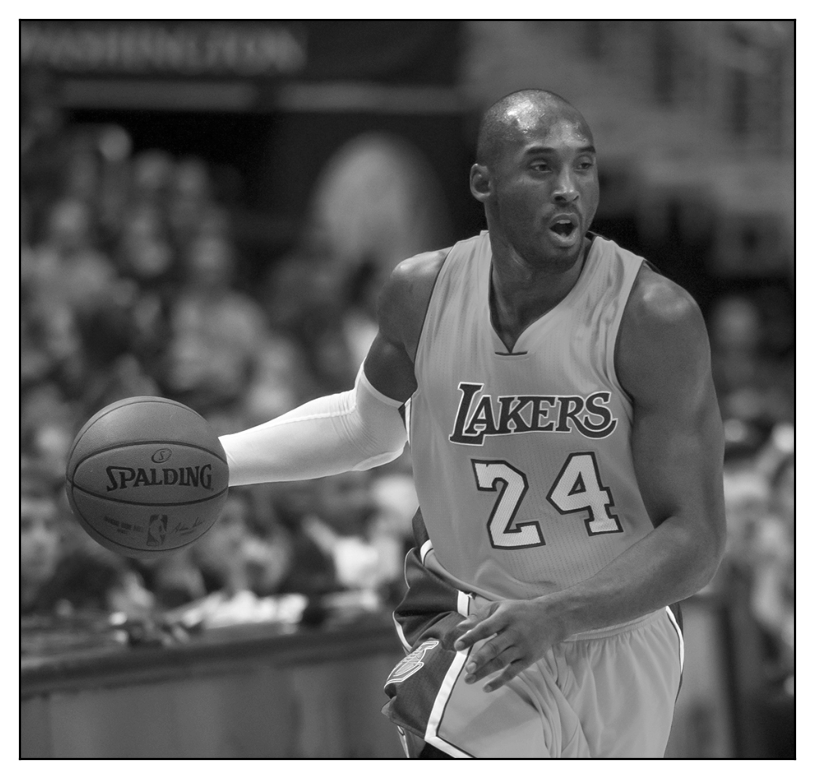

In [33]:
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
image = imageio.v2.imread('../data/Kobe_Bryant_2014.jpg')
image = image.mean(axis=2) # greyscale
display_image(image)
image.dtype, image.shape, image.min(), image.max()

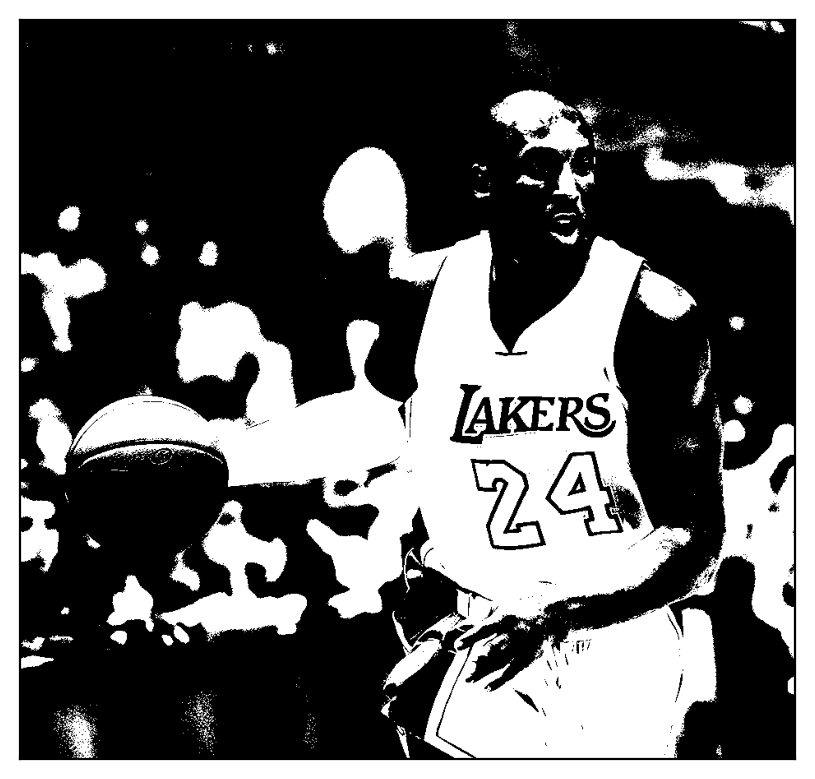

In [34]:
def segment(image, threshold=100):
    output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

display_image(segment(image))

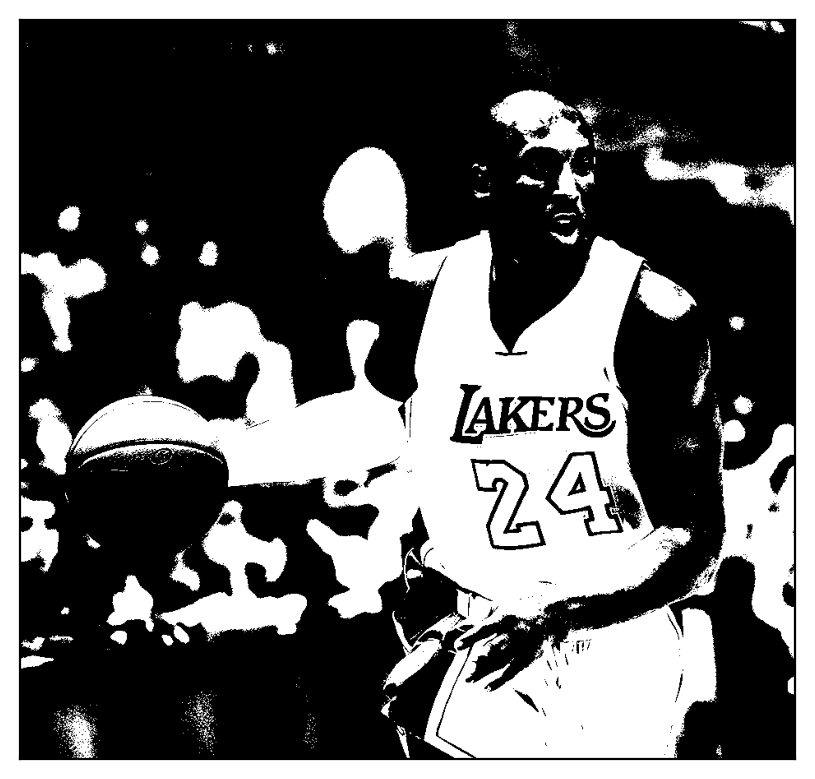

In [82]:
@numba.njit(nogil=True)
def _nsegment(image, threshold, output):
    n, m = image.shape
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0
    return output

def nsegment(image, threshold=100):
    output = np.empty_like(image)
    _nsegment(image, threshold, output)
    return output

display_image(nsegment(image))

In [83]:
%timeit segment(image)
%timeit nsegment(image)

2.41 ms ± 265 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.15 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


So on a single image Numba is 2-fold faster. 
What about using multi-threading for segmenting a bunch of images?

Let's download the 30 examples images from the [Berkeley Segmentation Dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/test-001-025.html).

![example](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg)

In [84]:
image_urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/{:d}.jpg'.format(i)
    for i in [119082,170057,58060,163085,42049,167062,157055,295087,24077,78004,220075,45096,38092,43074,16077,86000,101085,219090,89072,300091,126007,156065,76053,296007,175032]
]
image_urls[0]

'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/119082.jpg'

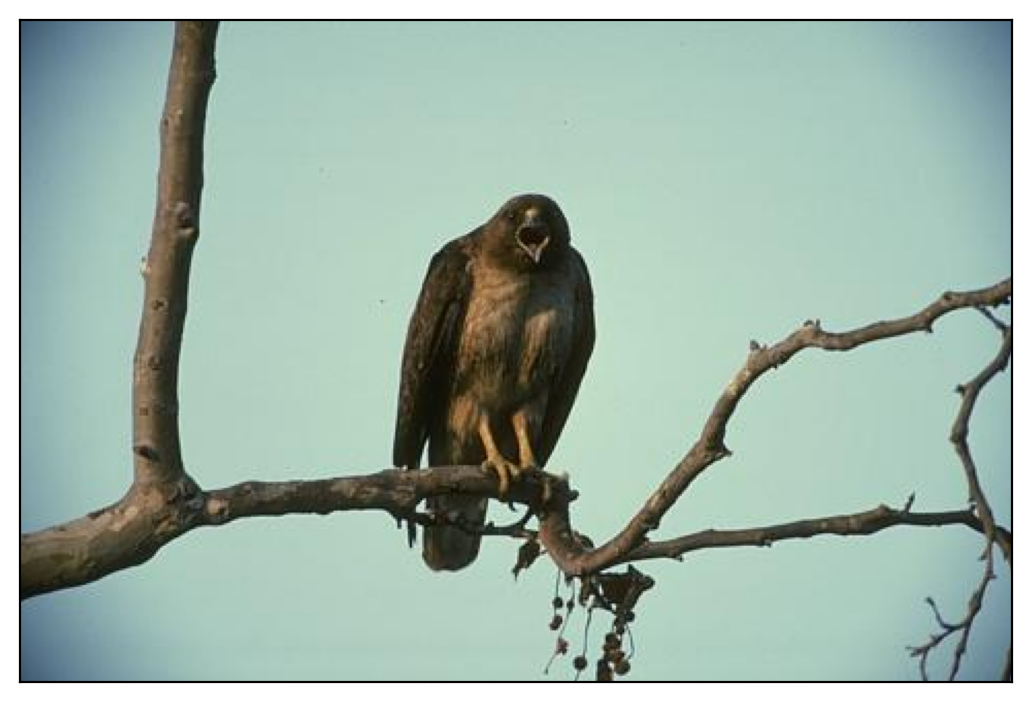

In [85]:
display_image(imageio.v2.imread(image_urls[4]))

Load and flatten the images:

In [86]:
images = [imageio.v2.imread(url) for url in image_urls]
images = [im.mean(axis=2) for im in images]

We resize the images so that the segmentation task is computationaly harder.

In [87]:
shapes = [im.shape for im in images]
images = [resize(im, (w*12, h*12), mode='reflect') 
          for im, (w, h) in zip(images, shapes)]

First compare the NumPy and Numba versions:

In [88]:
%timeit [segment(im) for im in images];
%timeit [nsegment(im) for im in images];

1.84 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.1 s ± 80 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's do it with multi-threading, leveraging the `nogil` directive.

In [89]:
from concurrent.futures import ThreadPoolExecutor

def psegment(images):     
    with ThreadPoolExecutor() as executor:        
        results = executor.map(nsegment, images)
        return list(results)    

In [90]:
%timeit psegment(images);

978 ms ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numba stencils (local filters)

Numba's `stencil` decorator works similar to SciPy's `generic_filter`, but uses the JIT capabilities of Numba.

Let's start by adding some noise to the images:

In [12]:
def salt_pepper(image, p=0.01):
    """Generates salt and pepper noise.
    
    Each pixel is "hit" independently with probability `p`. 
    If hit, a pixel has 1:1 chance of becoming white or black.
    """
    noisy = image.copy()
    rand = np.random.random(size=noisy.shape)
    mask_black = rand <= p/2
    noisy[mask_black] = 0
    mask_white = (p/2 < rand) & (rand <= p)
    noisy[mask_white] = 255
    return noisy

In [13]:
noisy = [salt_pepper(im, p=0.25) for im in images]

NameError: name 'images' is not defined

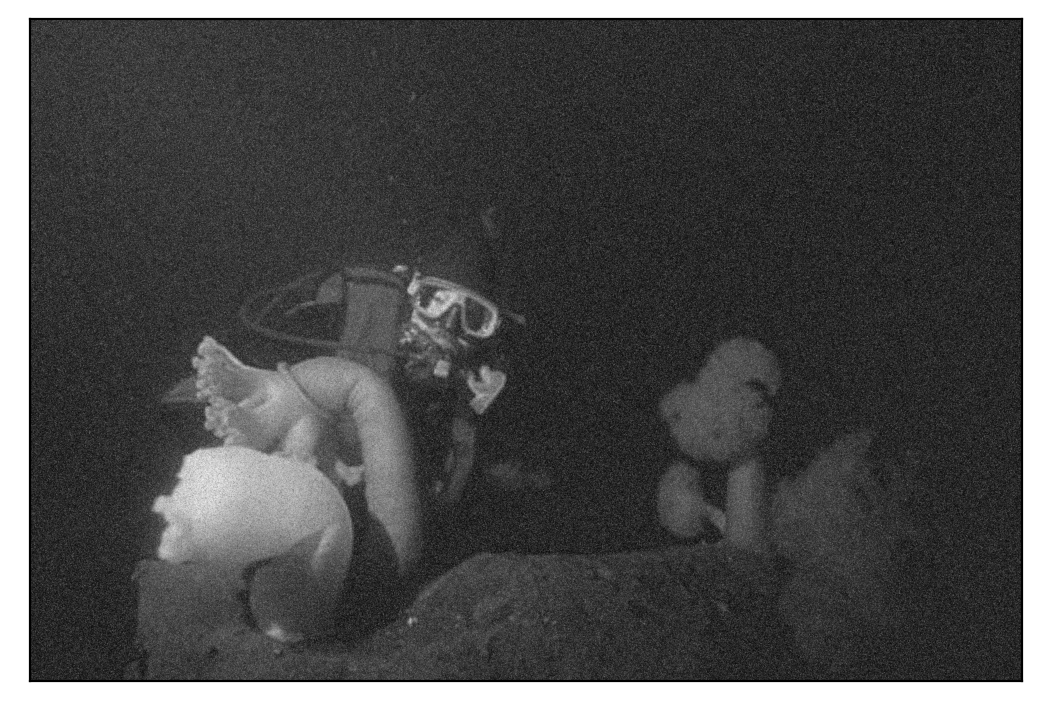

In [85]:
display_image(noisy[11])

Now let's clean the images with a bounded mean filter.

We write a `filter` function that accepts a 2D neighborhood, the dimensions of which can be specified in the `stencil` directive, and returns the stencil or local filter result.
The `stencil` decorator does the rest.

In [92]:
def local_bounded_mean_numba(image, black_th=5, white_th=250, k=5):
    # k = kernel size
    @numba.stencil(neighborhood=((-k, k), (-k, k)))
    def filter(neighbours):
        center_pixel = neighbours[0,0]
        if not black_th < center_pixel < center_pixel: # center_pixel is noisy
            summ, count = 0, 0 
            for i in range(-k, k+1):
                for j in range(-k, k+1):
                    pixel = neighbours[i,j]
                    if black_th <= pixel <= white_th: # neighbor pixel is not noisy
                        summ += pixel
                        count += 1
            if count > 0:
                return summ / count
        # either center was not extreme or all its neighbors are extreme
        return center_pixel
    
    return filter(image)

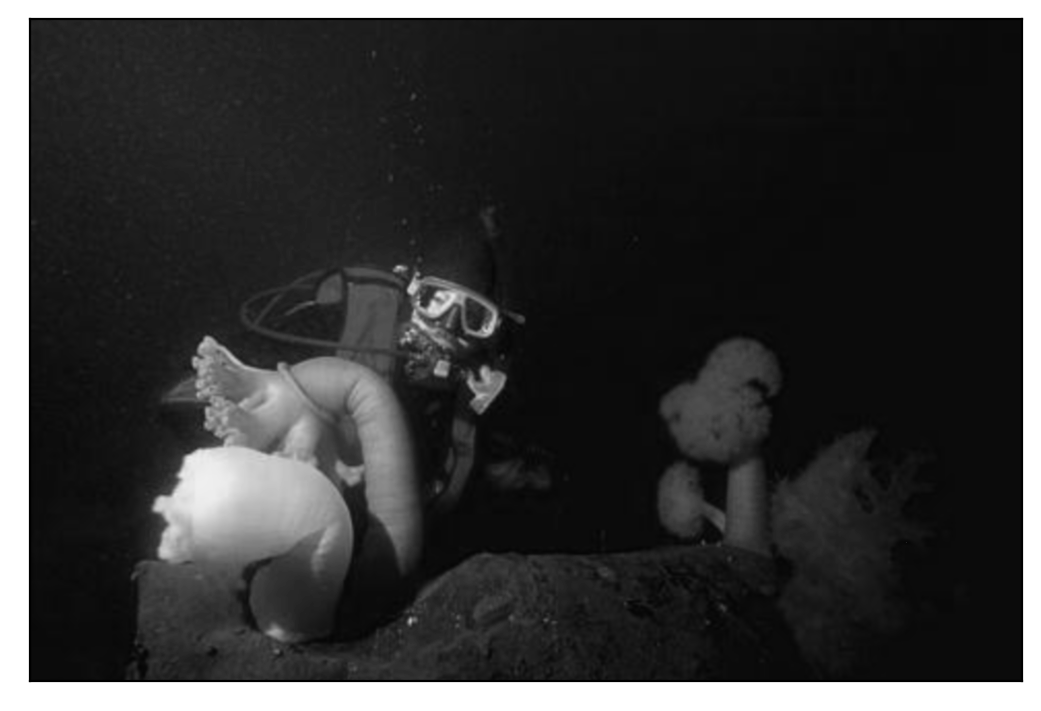

In [90]:
denoised = local_bounded_mean_numba(noisy[11])
display_image(denoised)

Compare this with the SciPy version, which uses [`generic_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html):

In [94]:
from scipy.ndimage import generic_filter

def local_bounded_mean_scipy(image, black_th=5, white_th=250, k=5):
    n = 2*k+1
    
    def filter(neighbours):
        center = neighbours.size // 2
        center_pixel = neighbours[center]
        if not black_th < center_pixel < center_pixel: # center_pixel is noisy
            mask = (black_th <= neighbours) & (neighbours <= white_th) # grab only non-noisy neighbors
            if mask.any():
                return neighbours[mask].mean()
        # either center was not extreme or all its neighbors are extreme
        return center_pixel

    return generic_filter(image, filter, size=(n, n))

In [95]:
%timeit -n 1 -r 1 local_bounded_mean_numba(noisy[0])
%timeit -n 1 -r 1 local_bounded_mean_scipy(noisy[0])

6.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


That's quite a difference...

# References

- [Numba](http://numba.pydata.org/)
- [Parallelization with Numba](https://www.anaconda.com/blog/developer-blog/parallel-python-with-numba-and-parallelaccelerator/)
- [Numexpr](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/user_guide.html)


# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)